In [ ]:
# Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1]:
# Loading previosly cleaned file

df_forecast = pd.read_csv('jobOrder_Clean.csv', delimiter='|')

df_forecast['LAUNCH_DATE'] = pd.to_datetime(df_forecast['LAUNCH_DATE'])
df_forecast['LAUNCH_DATE'] = df_forecast['LAUNCH_DATE'].dt.date

df_forecast

/var/folders/vt/tp70dkj96ss9h4qdh8lk86p80000gn/T/ipykernel_48809/2971630034.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_forecast = pd.read_csv('jobOrder_Clean.csv', delimiter='|')


,CONF_CODE,ORDER_ROW,JO_PROG,PRODUCT_CODE,MATERIAL_CODE,BASE_RADIUS,POWER,CYLINDER,POWER_AXIS,DIAMETER,CENTER_THK,LAUNCH_DATE,ItemCode,ItemName,LinProd,CodFam,CodSubFam
0,CH6997,5,0,VQ_ACTIVO,1001.0,8.7,9.0,-0.75,180.0,14.4,0.4268,2020-11-09,VQE,Blister Toric Rx,79.0,1.0,3.0
1,CH7603,9,0,VQ_ACTIVO,1001.0,8.7,4.0,-3.25,50.0,14.4,0.3041,2020-11-09,VQE,Blister Toric Rx,79.0,1.0,3.0
2,CI0727,6,0,VQ_ACTIVO,1001.0,8.7,9.0,-1.75,90.0,14.4,0.4428,2020-11-09,VQE,Blister Toric Rx,79.0,1.0,3.0
3,CI1456,9,0,VQ_ACTIVO,1001.0,8.7,0.5,-4.25,180.0,14.4,0.1901,2020-11-09,VQE,Blister Toric Rx,79.0,1.0,3.0
4,CI1456,A,0,VQ_ACTIVO,1001.0,8.7,0.5,-4.25,180.0,14.4,0.1901,2020-11-09,VQE,Blister Toric Rx,79.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4768676,IG7200,4,0,Y4V2_ACTIVO,7401.0,7.7,-2.5,-1.25,90.0,13.5,0.2480,2023-05-19,Y4N,Saphir Rx MFT CN Blister,1004.0,1.0,6.0
4768677,IG7200,5,0,Y4V2_ACTIVO,7401.0,7.7,-2.5,-1.25,90.0,13.5,0.2480,2023-05-19,Y4N,Saphir Rx MFT CN Blister,1004.0,1.0,6.0
4768678,IG7200,6,0,Y4V2_ACTIVO,7401.0,7.7,-2.5,-1.25,90.0,13.5,0.2480,2023-05-19,Y4N,Saphir Rx MFT CN Blister,1004.0,1.0,6.0
4768679,IG7383,1,0,7T_ACTIVO,1001.0,8.7,1.5,-3.75,180.0,14.4,0.2101,2023-05-20,VQE,Blister Toric Rx,79.0,1.0,3.0


In [2]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768681 entries, 0 to 4768680
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   CONF_CODE      object 
 1   ORDER_ROW      object 
 2   JO_PROG        object 
 3   PRODUCT_CODE   object 
 4   MATERIAL_CODE  float64
 5   BASE_RADIUS    float64
 6   POWER          float64
 7   CYLINDER       float64
 8   POWER_AXIS     float64
 9   DIAMETER       float64
 10  CENTER_THK     float64
 11  LAUNCH_DATE    object 
 12  ItemCode       object 
 13  ItemName       object 
 14  LinProd        float64
 15  CodFam         float64
 16  CodSubFam      float64
dtypes: float64(10), object(7)
memory usage: 618.5+ MB


In [3]:
# We carry out a group by to obtain the order count per day

grouped_df = df_forecast.groupby('LAUNCH_DATE').size().reset_index(name='ORDER_COUNT')
grouped_df

,LAUNCH_DATE,ORDER_COUNT
0,2019-12-31,477
1,2020-01-01,470
2,2020-01-02,4979
3,2020-01-03,5219
4,2020-01-04,1192
...,...,...
1076,2023-05-16,6165
1077,2023-05-17,4393
1078,2023-05-18,7030
1079,2023-05-19,6368


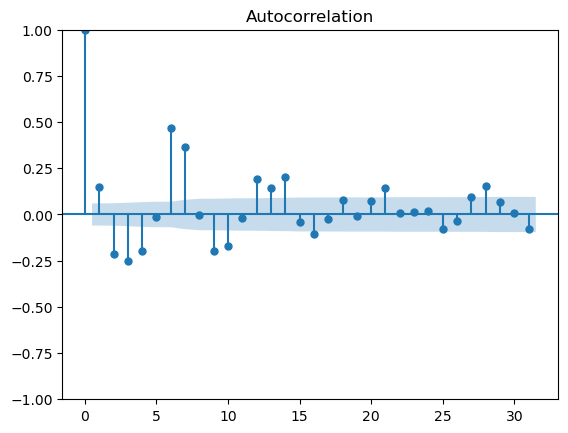

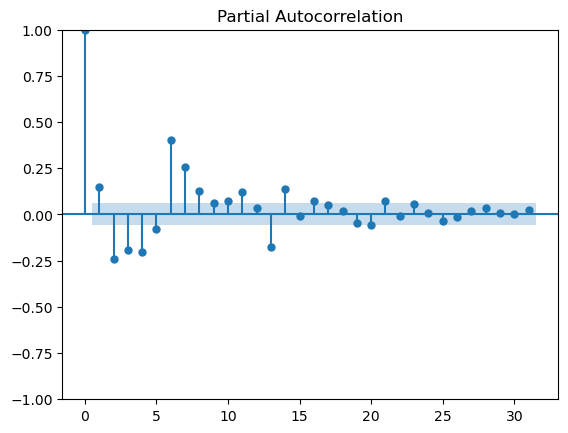

In [4]:
# Plot ACF
plot_acf(grouped_df['ORDER_COUNT'])
plt.show()

# Plot PACF
plot_pacf(grouped_df['ORDER_COUNT'], method='ywm')
plt.show()

In [5]:
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message= " This problem is unconstrained.")
warnings.filterwarnings("ignore")

In [6]:
# Define the range of values for p, d, and q
# The range (5, 4, 5) came. up because of the processing limitations of Anaconda.
# This process is computationally intensive as it creates and tries different combinations of parameters to find the best combination.
# Therefore, this range is the best we could find.
p = range(0, 5)
d = range(0, 4)
q = range(0, 5)

# Generate all possible combinations of p, d, and q values
parameters = product(p, d, q)

# Initialize variables to store best parameters and lowest AIC
best_aic = float('inf')
best_params = None

# Iterate over all parameter combinations
for param in parameters:
    try:
        # Fit SARIMA model with current parameters
        model = SARIMAX(grouped_df['ORDER_COUNT'], order=param)
        result = model.fit()

        # Check if current model has lower AIC than the best model so far
        if result.aic < best_aic:
            best_aic = result.aic
            best_params = param
    except:
        continue

# Print the best parameter values
print("Best parameter values: ", best_params)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91623D+00    |proj g|=  1.77636D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.776D-10   9.916D+00
  F =   9.9162283927493586     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.6

 This problem is unconstrained.



At iterate   20    f=  9.59635D+00    |proj g|=  2.53671D-02

At iterate   25    f=  9.57655D+00    |proj g|=  7.96010D-02

At iterate   30    f=  9.41141D+00    |proj g|=  5.03876D-02

At iterate   35    f=  9.40697D+00    |proj g|=  7.13636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     45      1     0     0   1.876D-06   9.407D+00
  F =   9.4069601661258027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  9.57333D+00    |proj g|=  1.26828D-02

At iterate   25    f=  9.55129D+00    |proj g|=  5.90682D-02

At iterate   30    f=  9.36908D+00    |proj g|=  1.21450D-01

At iterate   35    f=  9.34302D+00    |proj g|=  2.19739D-02

At iterate   40    f=  9.34269D+00    |proj g|=  7.69797D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     45      1     0     0   1.307D-06   9.343D+00
  F =   9.3426921801459279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34387D+00    |proj g|=  3.31823D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.318D-07   9.344D+00
  F =   9.3438702822631701     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.02543D+00    |proj g|=  3.60748D-03

At iterate   15    f=  9.02536D+00    |proj g|=  4.22217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     16      1     0     0   4.222D-05   9.025D+00
  F =   9.0253607182912674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43339D+00    |proj g|=  4.96111D-01

At iterate    5    f=  9.00690D+00    |proj g|=  3.82563D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.36239D+00    |proj g|=  1.05713D-03

At iterate   10    f=  9.35891D+00    |proj g|=  7.96092D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     15      1     0     0   3.417D-06   9.338D+00
  F =   9.3384658459991066     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00336D+01    |proj g|=  1.22234D+00

At iterate    5    f=  9.22042D+00    |proj g|=  4.55901D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01689D+01    |proj g|=  1.46562D+00

At iterate    5    f=  9.17666D+00    |proj g|=  8.32387D-02

At iterate   10    f=  9.13004D+00    |proj g|=  1.72174D-03

At iterate   15    f=  9.12864D+00    |proj g|=  4.81925D-03

At iterate   20    f=  9.12177D+00    |proj g|=  2.12331D-03

At iterate   25    f=  9.05801D+00    |proj g|=  6.70366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     48      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  9.08923D+00    |proj g|=  1.00166D-02

At iterate   20    f=  9.07982D+00    |proj g|=  1.11645D-03

At iterate   25    f=  9.07877D+00    |proj g|=  3.86696D-04

At iterate   30    f=  9.07465D+00    |proj g|=  7.61374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     55      1     0     0   1.786D-02   9.039D+00
  F =   9.0389820872993258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03596D+01    |proj g|=  3.53495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.535D-07   1.036D+01
  F =   10.359574213410399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65328D+00    |proj g|=  1.89035D-01

At iterate    5    f=  9.53249D+00    |proj g|=  2.98768D-03

At iterate   10    f=  9.52304D+00    |proj g|=  1.36343D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     41      2     0     0   9.017D-05   9.337D+00
  F =   9.3368935422288004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09773D+01    |proj g|=  2.33396D+00

At iterate    5    f=  9.54587D+00    |proj g|=  1.24787D-01

At iterate   10    f=  9.39029D+00    |proj g|=  3.07662D-03

At iterate   15    f=  9.38354D+00    |proj g|=  5.57687D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  9.29930D+00    |proj g|=  1.96565D-02

At iterate   15    f=  9.29278D+00    |proj g|=  1.77476D-02

At iterate   20    f=  9.28163D+00    |proj g|=  1.33980D-02

At iterate   25    f=  9.28051D+00    |proj g|=  6.10924D-03

At iterate   30    f=  9.27791D+00    |proj g|=  4.06733D-03

At iterate   35    f=  9.27781D+00    |proj g|=  1.02126D-03

At iterate   40    f=  9.27780D+00    |proj g|=  6.51053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     64      1     0     0   6.511D-04   9.278D+00
  F =   9.2778038330120030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31069D+00    |proj g|=  4.18190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   3.418D-07   9.311D+00
  F =   9.3106864554272821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.2

 This problem is unconstrained.



At iterate   25    f=  9.07416D+00    |proj g|=  7.00136D-03

At iterate   30    f=  9.07301D+00    |proj g|=  4.17511D-04

At iterate   35    f=  9.07277D+00    |proj g|=  1.32132D-04

At iterate   40    f=  9.07277D+00    |proj g|=  1.53894D-03

At iterate   45    f=  9.07223D+00    |proj g|=  1.22543D-02

At iterate   50    f=  9.06824D+00    |proj g|=  4.56161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     51      1     0     0   4.562D-04   9.068D+00
  F =   9.0682397422811718     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  9.03064D+00    |proj g|=  8.12334D-03

At iterate   25    f=  9.02992D+00    |proj g|=  4.44420D-04

At iterate   30    f=  9.02986D+00    |proj g|=  1.71582D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   1.024D-05   9.030D+00
  F =   9.0298559910118446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41420D+00    |proj g|=  4.72194D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  9.03716D+00    |proj g|=  3.60182D-02

At iterate   15    f=  9.00609D+00    |proj g|=  4.89094D-02

At iterate   20    f=  9.00132D+00    |proj g|=  4.02478D-03

At iterate   25    f=  9.00046D+00    |proj g|=  2.59605D-04

At iterate   30    f=  9.00045D+00    |proj g|=  7.56660D-05

At iterate   35    f=  9.00045D+00    |proj g|=  2.23212D-03

At iterate   40    f=  8.99994D+00    |proj g|=  2.20043D-02

At iterate   45    f=  8.99713D+00    |proj g|=  5.08823D-03

At iterate   50    f=  8.99549D+00    |proj g|=  3.69100D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30059D+00    |proj g|=  3.87633D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   1.535D-05   9.301D+00
  F =   9.3005866427000683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.1

 This problem is unconstrained.



At iterate   20    f=  9.06192D+00    |proj g|=  9.21377D-03

At iterate   25    f=  9.05641D+00    |proj g|=  6.97352D-03

At iterate   30    f=  9.05591D+00    |proj g|=  2.92525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     35      1     0     0   3.993D-06   9.056D+00
  F =   9.0559128644446094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46652D+00    |proj g|=  5.93061D-01

At iterate    5    f=  9.06343D+00    |proj g|=  2.66936D-02

At iterate   10    f=  9.05832D+00    |proj g|=  6.66744D-03

At iterate   15    f=  9.05590D+00    |proj g|=  2.04849D-03

At iterate   20    f=  9.05588D+00    |proj g|=  1.29941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   1.299D-05   9.056D+00
  F =   9.0558795933114098     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  9.01188D+00    |proj g|=  4.96552D-02

At iterate   10    f=  8.99182D+00    |proj g|=  1.90494D-02

At iterate   15    f=  8.99062D+00    |proj g|=  6.79706D-04

At iterate   20    f=  8.99062D+00    |proj g|=  8.34490D-05

At iterate   25    f=  8.99059D+00    |proj g|=  1.82410D-03

At iterate   30    f=  8.98800D+00    |proj g|=  4.14849D-02

At iterate   35    f=  8.98352D+00    |proj g|=  6.14841D-04

At iterate   40    f=  8.98347D+00    |proj g|=  1.60533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     47      1     0     0   1.090D-05   8.983D+00
  F =   8.98346523887

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.32911D+00    |proj g|=  4.38364D-04

At iterate   20    f=  9.29532D+00    |proj g|=  6.86217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   4.737D-06   9.295D+00
  F =   9.2952945981199875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02564D+01    |proj g|=  1.61054D+00

At iterate    5    f=  9.36650D+00    |proj g|=  8.46375D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  9.33124D+00    |proj g|=  2.63419D-04

At iterate   20    f=  9.33089D+00    |proj g|=  1.97755D-04

At iterate   25    f=  9.33067D+00    |proj g|=  1.31828D-03

At iterate   30    f=  9.32691D+00    |proj g|=  3.30721D-03

At iterate   35    f=  9.32662D+00    |proj g|=  4.74339D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     37      1     0     0   3.820D-06   9.327D+00
  F =   9.3266223301507267     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85121D+00    |proj g|=  6.80158D-01

At iterate    5    f=  9.15771D+00    |proj g|=  3.31243D-02

At iterate   10    f=  9.10836D+00    |proj g|=  3.10385D-03

At iterate   15    f=  9.10514D+00    |proj g|=  1.22219D-04

At iterate   20    f=  9.09354D+00    |proj g|=  4.13189D-03

At iterate   25    f=  9.07142D+00    |proj g|=  1.02366D-04

At iterate   30    f=  9.07140D+00    |proj g|=  9.23706D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  9.10993D+00    |proj g|=  4.93110D-03

At iterate   20    f=  9.10697D+00    |proj g|=  1.29427D-02

At iterate   25    f=  9.10189D+00    |proj g|=  8.06870D-03

At iterate   30    f=  9.05940D+00    |proj g|=  4.98642D-03

At iterate   35    f=  9.05766D+00    |proj g|=  9.67539D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     49      1     0     0   9.675D-05   9.058D+00
  F =   9.0576561641484510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04269D+01    |proj g|=  1.33402D+00

At iterate    5    f=  9.68001D+00    |proj g|=  3.61538D-02

At iterate   10    f=  9.65049D+00    |proj g|=  1.39842D-03

At iterate   15    f=  9.64729D+00    |proj g|=  1.14693D-03

At iterate   20    f=  9.64708D+00    |proj g|=  6.79969D-04


 This problem is unconstrained.



At iterate   25    f=  9.64657D+00    |proj g|=  2.81664D-02

At iterate   30    f=  9.63079D+00    |proj g|=  2.87539D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     37      1     0     0   2.875D-06   9.631D+00
  F =   9.6307854868971248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02157D+01    |proj g|=  8.74033D-01

At iterate    5    f=  9.48280D+00    |proj g|=  1.30189D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  9.44447D+00    |proj g|=  1.76406D-01

At iterate   25    f=  9.33880D+00    |proj g|=  1.07604D-01
  ys=-4.709E-03  -gs= 4.228E-03 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  9.29425D+00    |proj g|=  9.64244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     64      1     1     0   9.642D-04   9.294D+00
  F =   9.2942467381995328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03642D+01    |proj g|=  1.00749D+00

At iterate    5    f=  9.46370D+00    |proj g|=  3.12161D-02

At iterate   10    f=  9.39664D+00    |proj g|=  2.69991D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  9.27216D+00    |proj g|=  7.21838D-03

At iterate   15    f=  9.26377D+00    |proj g|=  1.82723D-03

At iterate   20    f=  9.25965D+00    |proj g|=  4.32739D-03

At iterate   25    f=  9.25784D+00    |proj g|=  1.18073D-03

At iterate   30    f=  9.25767D+00    |proj g|=  3.65870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     47      1     0     0   3.659D-04   9.258D+00
  F =   9.2576658696215901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  9.10723D+00    |proj g|=  4.68561D-03

At iterate   25    f=  9.10300D+00    |proj g|=  1.67926D-02

At iterate   30    f=  9.10228D+00    |proj g|=  1.86207D-03

At iterate   35    f=  9.10178D+00    |proj g|=  3.37354D-03

At iterate   40    f=  9.08978D+00    |proj g|=  1.12988D-01

At iterate   45    f=  9.07913D+00    |proj g|=  1.41850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     61      1     0     0   1.296D-04   9.079D+00
  F =   9.0791258177198539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  9.08421D+00    |proj g|=  4.17321D-04

At iterate   25    f=  9.08376D+00    |proj g|=  7.19600D-05

At iterate   30    f=  9.08249D+00    |proj g|=  1.27683D-04

At iterate   35    f=  9.08217D+00    |proj g|=  6.22560D-05

At iterate   40    f=  9.08215D+00    |proj g|=  1.54259D-05

At iterate   45    f=  9.08182D+00    |proj g|=  4.65993D-04

At iterate   50    f=  9.08122D+00    |proj g|=  1.03556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   1.036D-05   9.081D+00
  F =   9.0812155272164397     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45177D+00    |proj g|=  4.46194D-01

At iterate    5    f=  9.07827D+00    |proj g|=  1.55454D-02

At iterate   10    f=  9.07356D+00    |proj g|=  1.71923D-02

At iterate   15    f=  9.06666D+00    |proj g|=  4.96234D-03

At iterate   20    f=  9.06636D+00    |proj g|=  1.61266D-04

At iterate   25    f=  9.06635D+00    |proj g|=  2.52594D-03

At iterate   30    f=  9.06577D+00    |proj g|=  9.17511D-03

At iterate   35    f=  9.06513D+00    |proj g|=  1.00362D-03

At iterate   40    f=  9.06507D+00    |proj g|=  1.32555D-04

At iterate   45    f=  9.06507D+00    |proj g|=  1.42015D-04

At iterate   50    f=  9.06502D+00    |proj g|=  1.73313D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.02592D+00    |proj g|=  4.64330D-02

At iterate   10    f=  9.01441D+00    |proj g|=  1.14837D-02

At iterate   15    f=  9.00298D+00    |proj g|=  1.21025D-02

At iterate   20    f=  8.99977D+00    |proj g|=  1.52237D-02

At iterate   25    f=  8.99720D+00    |proj g|=  3.49053D-03

At iterate   30    f=  8.99701D+00    |proj g|=  3.04060D-04

At iterate   35    f=  8.99701D+00    |proj g|=  7.51431D-05

At iterate   40    f=  8.99701D+00    |proj g|=  9.66557D-04

At iterate   45    f=  8.99664D+00    |proj g|=  1.29497D-02

At iterate   50    f=  8.99329D+00    |proj g|=  1.21225D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14742D+00    |proj g|=  2.12125D-01

At iterate    5    f=  9.07593D+00    |proj g|=  3.77884D-02

At iterate   10    f=  9.06412D+00    |proj g|=  4.32003D-03

At iterate   15    f=  9.06340D+00    |proj g|=  1.29368D-04

At iterate   20    f=  9.06338D+00    |proj g|=  4.00491D-03

At iterate   25    f=  9.06128D+00    |proj g|=  5.17784D-02

At iterate   30    f=  9.03937D+00    |proj g|=  4.33936D-02

At iterate   35    f=  9.03209D+00    |proj g|=  3.35487D-02

At iterate   40    f=  9.03068D+00    |proj g|=  3.27180D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00785D+01    |proj g|=  1.64646D+00

At iterate    5    f=  9.10499D+00    |proj g|=  4.84702D-02

At iterate   10    f=  9.08553D+00    |proj g|=  1.02648D-02

At iterate   15    f=  9.05014D+00    |proj g|=  2.01984D-01

At iterate   20    f=  8.96472D+00    |proj g|=  4.25661D-02

At iterate   25    f=  8.96248D+00    |proj g|=  3.44873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   3.449D-05   8.962D+00
  F =   8.9624762032202

 This problem is unconstrained.



At iterate    5    f=  9.05418D+00    |proj g|=  5.35559D-02

At iterate   10    f=  9.03381D+00    |proj g|=  8.53254D-03

At iterate   15    f=  9.03304D+00    |proj g|=  2.15942D-03

At iterate   20    f=  9.03276D+00    |proj g|=  4.87825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   1.972D-05   9.033D+00
  F =   9.0327549025972580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  9.03464D+00    |proj g|=  1.65252D-02

At iterate   15    f=  9.03067D+00    |proj g|=  2.21631D-02

At iterate   20    f=  9.00876D+00    |proj g|=  4.12753D-02

At iterate   25    f=  8.98750D+00    |proj g|=  2.38255D-02

At iterate   30    f=  8.98572D+00    |proj g|=  6.06899D-03

At iterate   35    f=  8.98567D+00    |proj g|=  4.74200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     44      1     0     0   4.742D-05   8.986D+00
  F =   8.9856676423178836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53625D+00    |proj g|=  4.43687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   5.340D-06   9.536D+00
  F =   9.5362495618028262     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.4

 This problem is unconstrained.



At iterate    5    f=  9.32323D+00    |proj g|=  6.31182D-02

At iterate   10    f=  9.29492D+00    |proj g|=  1.79419D-02

At iterate   15    f=  9.24392D+00    |proj g|=  2.98701D-01

At iterate   20    f=  9.09350D+00    |proj g|=  3.24933D-02

At iterate   25    f=  9.07440D+00    |proj g|=  1.25841D-02

At iterate   30    f=  9.07316D+00    |proj g|=  3.66634D-03

At iterate   35    f=  9.07047D+00    |proj g|=  4.59957D-03

At iterate   40    f=  9.07011D+00    |proj g|=  1.70206D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     56      1     0     0   1.836D-03   9.070D+00
  F =   9.07010758213

 This problem is unconstrained.



At iterate   10    f=  9.32244D+00    |proj g|=  3.91565D-01

At iterate   15    f=  9.30651D+00    |proj g|=  2.63793D-02

At iterate   20    f=  9.30266D+00    |proj g|=  2.89872D-02

At iterate   25    f=  9.30157D+00    |proj g|=  3.99310D-02

At iterate   30    f=  9.29774D+00    |proj g|=  6.65540D-03

At iterate   35    f=  9.29716D+00    |proj g|=  5.47581D-03

At iterate   40    f=  9.29700D+00    |proj g|=  5.54220D-03

At iterate   45    f=  9.29664D+00    |proj g|=  2.87218D-02

At iterate   50    f=  9.28720D+00    |proj g|=  9.44314D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.



At iterate    5    f=  9.26246D+00    |proj g|=  1.76224D-01

At iterate   10    f=  9.09777D+00    |proj g|=  5.00655D-02

At iterate   15    f=  9.08522D+00    |proj g|=  6.07988D-03

At iterate   20    f=  9.08489D+00    |proj g|=  1.74288D-02

At iterate   25    f=  9.08467D+00    |proj g|=  4.45270D-02

At iterate   30    f=  9.08245D+00    |proj g|=  1.79364D-01

At iterate   35    f=  9.07841D+00    |proj g|=  2.17243D-01

At iterate   40    f=  9.07703D+00    |proj g|=  9.26526D-02

At iterate   45    f=  9.07589D+00    |proj g|=  1.00384D-01

At iterate   50    f=  9.07540D+00    |proj g|=  1.40744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.57527D+00    |proj g|=  5.18626D-04

At iterate   15    f=  9.57401D+00    |proj g|=  2.02336D-03

At iterate   20    f=  9.57394D+00    |proj g|=  1.42308D-03

At iterate   25    f=  9.57392D+00    |proj g|=  1.41472D-03

At iterate   30    f=  9.53148D+00    |proj g|=  3.54426D-02

At iterate   35    f=  9.53031D+00    |proj g|=  8.12896D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     44      1     0     0   8.129D-06   9.530D+00
  F =   9.5303063687212735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  9.43432D+00    |proj g|=  4.67218D-02

At iterate   20    f=  9.40159D+00    |proj g|=  1.45225D-03

At iterate   25    f=  9.39958D+00    |proj g|=  1.53469D-03

At iterate   30    f=  9.39952D+00    |proj g|=  3.05562D-04

At iterate   35    f=  9.39944D+00    |proj g|=  3.62962D-03

At iterate   40    f=  9.31047D+00    |proj g|=  2.19936D-01

At iterate   45    f=  9.24990D+00    |proj g|=  7.11859D-03
  ys=-1.439E-03  -gs= 4.790E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f=  9.24917D+00    |proj g|=  1.96101D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     96      2     1     0   1.961D-03   9.249D+00
  F =   9.2491721938143776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01948D+01    |proj g|=  9.51932D-01

At iterate    5    f=  9.67421D+00    |proj g|=  1.84658D-01

At iterate   10    f=  9.36894D+00    |proj g|=  8.34786D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  9.55724D+00    |proj g|=  4.60661D-01

At iterate   10    f=  9.36750D+00    |proj g|=  5.56268D-02

At iterate   15    f=  9.35407D+00    |proj g|=  3.23095D-02

At iterate   20    f=  9.34875D+00    |proj g|=  2.72019D-02

At iterate   25    f=  9.34830D+00    |proj g|=  3.28901D-02

At iterate   30    f=  9.34805D+00    |proj g|=  7.15755D-04

At iterate   35    f=  9.34804D+00    |proj g|=  1.05131D-02

At iterate   40    f=  9.34793D+00    |proj g|=  1.34301D-02

At iterate   45    f=  9.34792D+00    |proj g|=  1.46384D-03

At iterate   50    f=  9.34790D+00    |proj g|=  1.34381D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24959D+00    |proj g|=  3.80757D-04

At iterate    5    f=  9.24959D+00    |proj g|=  1.32039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   6.184D-06   9.250D+00
  F =   9.2495871937108483     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  9.15627D+00    |proj g|=  9.84583D-02

At iterate   20    f=  9.09349D+00    |proj g|=  2.33029D-02

At iterate   25    f=  9.08586D+00    |proj g|=  3.20915D-03

At iterate   30    f=  9.08360D+00    |proj g|=  1.22317D-03

At iterate   35    f=  9.08352D+00    |proj g|=  2.39426D-03

At iterate   40    f=  9.08328D+00    |proj g|=  2.94527D-04

At iterate   45    f=  9.08304D+00    |proj g|=  1.09960D-04

At iterate   50    f=  9.08234D+00    |proj g|=  3.51533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   3.515D-02   9.082D+00
  F =   9.08234458506

 This problem is unconstrained.


At iterate   10    f=  9.09546D+00    |proj g|=  7.03466D-02

At iterate   15    f=  9.06647D+00    |proj g|=  8.43332D-02

At iterate   20    f=  9.06309D+00    |proj g|=  1.98348D-02

At iterate   25    f=  9.05061D+00    |proj g|=  1.38024D-01

At iterate   30    f=  9.04531D+00    |proj g|=  7.15959D-03

At iterate   35    f=  9.04273D+00    |proj g|=  3.26519D-02

At iterate   40    f=  9.04202D+00    |proj g|=  7.80589D-03

At iterate   45    f=  9.04088D+00    |proj g|=  1.78139D-03

At iterate   50    f=  9.04081D+00    |proj g|=  7.26779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68    

 This problem is unconstrained.



At iterate    5    f=  9.09467D+00    |proj g|=  6.52153D-02

At iterate   10    f=  9.06381D+00    |proj g|=  9.09944D-02

At iterate   15    f=  9.04828D+00    |proj g|=  2.82293D-02

At iterate   20    f=  9.04709D+00    |proj g|=  1.28270D-02

At iterate   25    f=  9.02338D+00    |proj g|=  1.18986D-01

At iterate   30    f=  8.99503D+00    |proj g|=  1.90517D-02

At iterate   35    f=  8.99317D+00    |proj g|=  1.22934D-03

At iterate   40    f=  8.99301D+00    |proj g|=  1.32042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     58      1     0     0   3.787D-05   8.993D+00
  F =   8.99301133097

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.05334D+00    |proj g|=  2.07428D-02

At iterate   10    f=  9.04370D+00    |proj g|=  2.05564D-03

At iterate   15    f=  9.04359D+00    |proj g|=  2.12416D-04

At iterate   20    f=  9.04358D+00    |proj g|=  1.48552D-03

At iterate   25    f=  9.04313D+00    |proj g|=  1.99501D-02

At iterate   30    f=  9.01408D+00    |proj g|=  1.16476D-01

At iterate   35    f=  9.00219D+00    |proj g|=  1.46101D-03

At iterate   40    f=  9.00098D+00    |proj g|=  1.75749D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     52      1     0     0   7.553D-05   9.001D+00
  F =   9.00074830510

 This problem is unconstrained.



At iterate   15    f=  9.03793D+00    |proj g|=  2.40658D-02

At iterate   20    f=  9.03121D+00    |proj g|=  2.95897D-02

At iterate   25    f=  9.02983D+00    |proj g|=  9.20308D-03

At iterate   30    f=  9.02875D+00    |proj g|=  8.15431D-03

At iterate   35    f=  9.02864D+00    |proj g|=  1.22814D-04

At iterate   40    f=  9.02859D+00    |proj g|=  2.66952D-03

At iterate   45    f=  9.02480D+00    |proj g|=  2.76600D-02

At iterate   50    f=  9.02200D+00    |proj g|=  3.40489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.405D-03   9.022D+00
  F =   9.02200142970

 This problem is unconstrained.



At iterate   10    f=  9.02989D+00    |proj g|=  7.75258D-02

At iterate   15    f=  8.99441D+00    |proj g|=  5.17276D-02

At iterate   20    f=  8.96159D+00    |proj g|=  2.25329D-02

At iterate   25    f=  8.95968D+00    |proj g|=  3.83509D-03

At iterate   30    f=  8.95775D+00    |proj g|=  7.56872D-03

At iterate   35    f=  8.95754D+00    |proj g|=  2.40640D-04

At iterate   40    f=  8.95754D+00    |proj g|=  6.84302D-05

At iterate   45    f=  8.95752D+00    |proj g|=  2.56183D-03

At iterate   50    f=  8.95543D+00    |proj g|=  1.47701D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59047D+00    |proj g|=  1.42891D+00

At iterate    5    f=  9.06380D+00    |proj g|=  3.87722D-02

At iterate   10    f=  9.02626D+00    |proj g|=  1.71294D-01

At iterate   15    f=  8.99671D+00    |proj g|=  1.35852D-01

At iterate   20    f=  8.98577D+00    |proj g|=  2.90463D-02

At iterate   25    f=  8.96123D+00    |proj g|=  8.85167D-02

At iterate   30    f=  8.92123D+00    |proj g|=  5.52366D-02

At iterate   35    f=  8.91780D+00    |proj g|=  1.83180D-02

At iterate   40    f=  8.91752D+00    |proj g|=  8.31483D-03

At iterate   45    f=  8.91718D+00    |proj g|=  1.74811D-02

At iterate   50    f=  8.91695D+00    |proj g|=  2.54926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.28059D+00    |proj g|=  7.78325D-03

At iterate   15    f=  9.27911D+00    |proj g|=  5.40292D-04

At iterate   20    f=  9.27901D+00    |proj g|=  2.33117D-04

At iterate   25    f=  9.21957D+00    |proj g|=  6.01238D-02

At iterate   30    f=  9.21707D+00    |proj g|=  2.96048D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     42      1     0     0   2.960D-06   9.217D+00
  F =   9.2170699449750018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  9.24617D+00    |proj g|=  3.68914D-02

At iterate   15    f=  9.23604D+00    |proj g|=  1.63729D-03

At iterate   20    f=  9.23580D+00    |proj g|=  3.71765D-03

At iterate   25    f=  9.23426D+00    |proj g|=  5.82468D-03

At iterate   30    f=  9.23394D+00    |proj g|=  1.67394D-03

At iterate   35    f=  9.23390D+00    |proj g|=  2.73884D-03

At iterate   40    f=  9.23386D+00    |proj g|=  6.17356D-04

At iterate   45    f=  9.23264D+00    |proj g|=  1.43489D-02

At iterate   50    f=  9.23176D+00    |proj g|=  2.13087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84397D+00    |proj g|=  1.19303D+00

At iterate    5    f=  9.29440D+00    |proj g|=  1.84363D-01

At iterate   10    f=  9.26137D+00    |proj g|=  1.05035D-02

At iterate   15    f=  9.25864D+00    |proj g|=  4.86759D-03

At iterate   20    f=  9.25531D+00    |proj g|=  1.09781D-02

At iterate   25    f=  9.25464D+00    |proj g|=  2.75207D-03

At iterate   30    f=  9.25444D+00    |proj g|=  1.33601D-03

At iterate   35    f=  9.25438D+00    |proj g|=  1.59614D-03

At iterate   40    f=  9.25259D+00    |proj g|=  1.81584D-02

At iterate   45    f=  9.24644D+00    |proj g|=  9.13476D-03

At iterate   50    f=  9.24621D+00    |proj g|=  1.46362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.31298D+00    |proj g|=  1.86880D-01

At iterate   10    f=  9.28699D+00    |proj g|=  5.75628D-02

At iterate   15    f=  9.24959D+00    |proj g|=  1.52150D-01

At iterate   20    f=  9.12098D+00    |proj g|=  1.69046D-01

At iterate   25    f=  9.09485D+00    |proj g|=  1.66494D-01

At iterate   30    f=  9.08590D+00    |proj g|=  2.81181D-01

At iterate   35    f=  9.08355D+00    |proj g|=  3.69211D-02

At iterate   40    f=  9.08083D+00    |proj g|=  1.99432D-01

At iterate   45    f=  9.07701D+00    |proj g|=  6.52608D-02

At iterate   50    f=  9.07632D+00    |proj g|=  4.78373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.56224D+00    |proj g|=  2.81955D-02

At iterate   10    f=  9.54601D+00    |proj g|=  4.05038D-03

At iterate   15    f=  9.54360D+00    |proj g|=  7.39754D-03

At iterate   20    f=  9.54343D+00    |proj g|=  2.53368D-04

At iterate   25    f=  9.54342D+00    |proj g|=  3.98580D-03

At iterate   30    f=  9.53905D+00    |proj g|=  4.47236D-02

At iterate   35    f=  9.48040D+00    |proj g|=  2.91224D-02

At iterate   40    f=  9.47991D+00    |proj g|=  6.88676D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     46      1     0     0   6.887D-06   9.480D+00
  F =   9.47990711980

 This problem is unconstrained.



At iterate   10    f=  9.51571D+00    |proj g|=  3.47986D-02

At iterate   15    f=  9.50906D+00    |proj g|=  1.52792D-02

At iterate   20    f=  9.50723D+00    |proj g|=  8.03238D-03

At iterate   25    f=  9.49415D+00    |proj g|=  1.11507D-01

At iterate   30    f=  9.44292D+00    |proj g|=  1.64550D-01

At iterate   35    f=  9.35136D+00    |proj g|=  5.74681D-02

At iterate   40    f=  9.33199D+00    |proj g|=  8.23278D-03

At iterate   45    f=  9.33050D+00    |proj g|=  3.75678D-03

At iterate   50    f=  9.33044D+00    |proj g|=  2.42096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74   

 This problem is unconstrained.



At iterate   15    f=  9.55175D+00    |proj g|=  2.07795D-01

At iterate   20    f=  9.27351D+00    |proj g|=  7.96773D-02

At iterate   25    f=  9.24654D+00    |proj g|=  2.39438D-02

At iterate   30    f=  9.24600D+00    |proj g|=  4.69187D-03

At iterate   35    f=  9.24513D+00    |proj g|=  1.30433D-03

At iterate   40    f=  9.24511D+00    |proj g|=  6.65147D-04

At iterate   45    f=  9.24501D+00    |proj g|=  7.57093D-04

At iterate   50    f=  9.24500D+00    |proj g|=  2.64074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.641D-04   9.245D+00
  F =   9.24500439858

 This problem is unconstrained.



At iterate    5    f=  9.63004D+00    |proj g|=  1.78370D-01

At iterate   10    f=  9.38379D+00    |proj g|=  5.91470D-01

At iterate   15    f=  9.31895D+00    |proj g|=  2.08335D-01

At iterate   20    f=  9.29295D+00    |proj g|=  1.89244D-01

At iterate   25    f=  9.29105D+00    |proj g|=  3.31797D-02

At iterate   30    f=  9.29097D+00    |proj g|=  1.08363D-02

At iterate   35    f=  9.29062D+00    |proj g|=  2.12664D-02

At iterate   40    f=  9.28655D+00    |proj g|=  8.58146D-02

At iterate   45    f=  9.28650D+00    |proj g|=  2.03248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     58   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22216D+00    |proj g|=  1.76595D-03

At iterate    5    f=  9.22215D+00    |proj g|=  4.68026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   9.727D-06   9.222D+00
  F =   9.2221516333708333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  9.11857D+00    |proj g|=  8.30038D-02

At iterate   20    f=  9.04675D+00    |proj g|=  7.93509D-03

At iterate   25    f=  9.04377D+00    |proj g|=  1.76222D-03

At iterate   30    f=  9.04295D+00    |proj g|=  9.20824D-03

At iterate   35    f=  9.04290D+00    |proj g|=  9.83587D-05

At iterate   40    f=  9.04289D+00    |proj g|=  3.43409D-03

At iterate   45    f=  9.04263D+00    |proj g|=  1.11952D-02

At iterate   50    f=  9.04210D+00    |proj g|=  2.86610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   2.866D-04   9.042D+00
  F =   9.04209653318

 This problem is unconstrained.


At iterate    5    f=  9.35928D+00    |proj g|=  8.73802D-02

At iterate   10    f=  9.22403D+00    |proj g|=  3.36512D-01

At iterate   15    f=  9.09948D+00    |proj g|=  1.74824D-01

At iterate   20    f=  9.08054D+00    |proj g|=  7.51368D-02

At iterate   25    f=  9.07120D+00    |proj g|=  2.16861D-02

At iterate   30    f=  9.07065D+00    |proj g|=  1.09924D-02

At iterate   35    f=  9.06632D+00    |proj g|=  3.12963D-02

At iterate   40    f=  9.06594D+00    |proj g|=  2.94326D-03

At iterate   45    f=  9.06560D+00    |proj g|=  6.50113D-03

At iterate   50    f=  9.06504D+00    |proj g|=  6.18343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate   10    f=  9.03834D+00    |proj g|=  1.07739D-01

At iterate   15    f=  9.01192D+00    |proj g|=  9.37298D-02

At iterate   20    f=  9.00467D+00    |proj g|=  8.06817D-02

At iterate   25    f=  8.99811D+00    |proj g|=  2.97677D-02

At iterate   30    f=  8.94524D+00    |proj g|=  2.09237D-01

At iterate   35    f=  8.93500D+00    |proj g|=  9.11928D-03

At iterate   40    f=  8.92947D+00    |proj g|=  1.33292D-02

At iterate   45    f=  8.92843D+00    |proj g|=  1.14258D-02

At iterate   50    f=  8.92528D+00    |proj g|=  4.73431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     69   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      6      1     0     0   2.950D-05   9.169D+00
  F =   9.1694177245340640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09771D+00    |proj g|=  2.37739D-01

At iterate    5    f=  8.99275D+00    |proj g|=  1.55990D-02

At iterate   10    f=  8.98920D+00    |proj g|=  3.95480D-04

At iterate   15    f=  8.98920D+00    |proj g|=  7.87187D-04

At iter

 This problem is unconstrained.



At iterate   10    f=  9.00869D+00    |proj g|=  1.73213D-02

At iterate   15    f=  8.93912D+00    |proj g|=  1.68722D-01

At iterate   20    f=  8.90783D+00    |proj g|=  1.58612D-02

At iterate   25    f=  8.90750D+00    |proj g|=  3.47109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     34      1     0     0   1.082D-05   8.907D+00
  F =   8.9074969071568724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.99569D+00    |proj g|=  8.71013D-02

At iterate   10    f=  8.91176D+00    |proj g|=  4.66498D-02

At iterate   15    f=  8.90075D+00    |proj g|=  9.83159D-03

At iterate   20    f=  8.90024D+00    |proj g|=  5.89849D-04

At iterate   25    f=  8.90023D+00    |proj g|=  2.16281D-04

At iterate   30    f=  8.90023D+00    |proj g|=  2.76286D-04

At iterate   35    f=  8.90023D+00    |proj g|=  1.19017D-03

At iterate   40    f=  8.90000D+00    |proj g|=  4.98780D-03

At iterate   45    f=  8.89812D+00    |proj g|=  2.79221D-02

At iterate   50    f=  8.89101D+00    |proj g|=  8.17154D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.02070D+00    |proj g|=  2.02179D-01

At iterate   10    f=  8.89834D+00    |proj g|=  7.58510D-02

At iterate   15    f=  8.88953D+00    |proj g|=  3.65106D-02

At iterate   20    f=  8.88854D+00    |proj g|=  9.79072D-04

At iterate   25    f=  8.88853D+00    |proj g|=  6.13653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     31      1     0     0   1.220D-04   8.889D+00
  F =   8.8885258755214949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37848D+00    |proj g|=  1.90868D-01

At iterate    5    f=  9.25943D+00    |proj g|=  3.38912D-02

At iterate   10    f=  9.24532D+00    |proj g|=  9.73114D-03

At iterate   15    f=  9.24352D+00    |proj g|=  5.07070D-04

At iterate   20    f=  9.24343D+00    |proj g|=  1.69058D-04

At iterate   25    f=  9.24343D+00    |proj g|=  5.14918D-04

At iterate   30    f=  9.24101D+00    |proj g|=  4.85972D-02

At iterate   35    f=  9.16544D+00    |proj g|=  1.70028D-02

At iterate   40    f=  9.16503D+00    |proj g|=  1.02787D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   15    f=  9.21659D+00    |proj g|=  5.58915D-03

At iterate   20    f=  9.21624D+00    |proj g|=  3.49461D-04

At iterate   25    f=  9.21624D+00    |proj g|=  6.89145D-04

At iterate   30    f=  9.21617D+00    |proj g|=  6.54175D-03

At iterate   35    f=  9.21602D+00    |proj g|=  2.42860D-03

At iterate   40    f=  9.21454D+00    |proj g|=  1.29062D-02

At iterate   45    f=  9.21440D+00    |proj g|=  9.75772D-05

At iterate   50    f=  9.21440D+00    |proj g|=  1.41126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     51      1     0     0   1.411D-05   9.214D+00
  F =   9.21439584199

 This problem is unconstrained.



At iterate    5    f=  9.33280D+00    |proj g|=  1.74187D-01

At iterate   10    f=  9.24171D+00    |proj g|=  3.57222D-02

At iterate   15    f=  9.23738D+00    |proj g|=  1.67621D-02

At iterate   20    f=  9.23441D+00    |proj g|=  9.72664D-03

At iterate   25    f=  9.23379D+00    |proj g|=  6.68410D-03

At iterate   30    f=  9.23369D+00    |proj g|=  1.51742D-04

At iterate   35    f=  9.23368D+00    |proj g|=  2.72000D-03

At iterate   40    f=  9.23363D+00    |proj g|=  2.38501D-03

At iterate   45    f=  9.23359D+00    |proj g|=  4.38288D-03

At iterate   50    f=  9.23355D+00    |proj g|=  5.26328D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  9.26614D+00    |proj g|=  5.66416D-02

At iterate   15    f=  9.24621D+00    |proj g|=  3.82842D-02

At iterate   20    f=  9.21277D+00    |proj g|=  3.20493D-01

At iterate   25    f=  9.08431D+00    |proj g|=  2.38778D-01

At iterate   30    f=  9.06663D+00    |proj g|=  1.07344D-01

At iterate   35    f=  9.06107D+00    |proj g|=  4.37339D-02

At iterate   40    f=  9.05699D+00    |proj g|=  6.81846D-02

At iterate   45    f=  9.05144D+00    |proj g|=  5.09400D-02

At iterate   50    f=  9.05022D+00    |proj g|=  2.69957D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.55051D+00    |proj g|=  3.04742D-02

At iterate   10    f=  9.53275D+00    |proj g|=  2.04819D-02

At iterate   15    f=  9.52953D+00    |proj g|=  2.17214D-03

At iterate   20    f=  9.52932D+00    |proj g|=  3.78773D-04

At iterate   25    f=  9.52932D+00    |proj g|=  1.39025D-04

At iterate   30    f=  9.52171D+00    |proj g|=  6.97816D-02

At iterate   35    f=  9.46472D+00    |proj g|=  5.72356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     47      1     0     0   1.353D-04   9.465D+00
  F =   9.4646879991527726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  9.48191D+00    |proj g|=  1.33379D-02

At iterate   20    f=  9.47930D+00    |proj g|=  5.80692D-03

At iterate   25    f=  9.47918D+00    |proj g|=  1.56438D-04

At iterate   30    f=  9.47917D+00    |proj g|=  2.33444D-03

At iterate   35    f=  9.47903D+00    |proj g|=  3.30430D-03

At iterate   40    f=  9.47900D+00    |proj g|=  1.79256D-03

At iterate   45    f=  9.47888D+00    |proj g|=  1.38976D-02

At iterate   50    f=  9.47628D+00    |proj g|=  1.40069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   1.401D-03   9.476D+00
  F =   9.47627939293

 This problem is unconstrained.


At iterate    5    f=  9.60887D+00    |proj g|=  1.14039D-01

At iterate   10    f=  9.55377D+00    |proj g|=  3.82684D-02

At iterate   15    f=  9.55022D+00    |proj g|=  4.24906D-03

At iterate   20    f=  9.54863D+00    |proj g|=  1.07545D-02

At iterate   25    f=  9.54817D+00    |proj g|=  6.38169D-03

At iterate   30    f=  9.54770D+00    |proj g|=  3.17486D-03

At iterate   35    f=  9.54745D+00    |proj g|=  5.42301D-03

At iterate   40    f=  9.54358D+00    |proj g|=  3.05981D-02

At iterate   45    f=  9.50738D+00    |proj g|=  7.78873D-02

At iterate   50    f=  9.50003D+00    |proj g|=  1.46403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04219D+01    |proj g|=  2.53686D+00

At iterate    5    f=  9.58429D+00    |proj g|=  1.26289D-01

At iterate   10    f=  9.41282D+00    |proj g|=  1.64139D-01

At iterate   15    f=  9.31488D+00    |proj g|=  7.25598D-01

At iterate   20    f=  9.26066D+00    |proj g|=  8.76660D-02

At iterate   25    f=  9.25829D+00    |proj g|=  2.15886D-02

At iterate   30    f=  9.25812D+00    |proj g|=  6.10539D-03

At iterate   35    f=  9.25811D+00    |proj g|=  2.09654D-03

At iterate   40    f=  9.25792D+00    |proj g|=  1.61971D-02

At iterate   45    f=  9.25708D+00    |proj g|=  9.15561D-02

At iterate   50    f=  9.25692D+00    |proj g|=  1.44549D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [7]:
# Convert the "LAUNCH_DATE" column to datetime format
grouped_df['LAUNCH_DATE'] = pd.to_datetime(grouped_df['LAUNCH_DATE'])

# Set the "LAUNCH_DATE" column as the index
grouped_df.set_index('LAUNCH_DATE', inplace=True)

In [8]:
grouped_df

,ORDER_COUNT
LAUNCH_DATE,
2019-12-31,477
2020-01-01,470
2020-01-02,4979
2020-01-03,5219
2020-01-04,1192
...,...
2023-05-16,6165
2023-05-17,4393
2023-05-18,7030


In [9]:
# We remove the dates we don't want to be working with, such as 2019 data and the last month of our records (2023-05-31), because its incomplete

grouped_df_monthly = grouped_df.groupby(pd.Grouper(freq='M')).sum()
grouped_df_monthly = grouped_df_monthly[grouped_df_monthly.index != '2019-12-31']
grouped_df_monthly = grouped_df_monthly[grouped_df_monthly.index != '2023-05-31']
grouped_df_monthly

,ORDER_COUNT
LAUNCH_DATE,
2020-01-31,126830
2020-02-29,119021
2020-03-31,101725
2020-04-30,47158
2020-05-31,67169
2020-06-30,112339
2020-07-31,134229
2020-08-31,94570
2020-09-30,110118


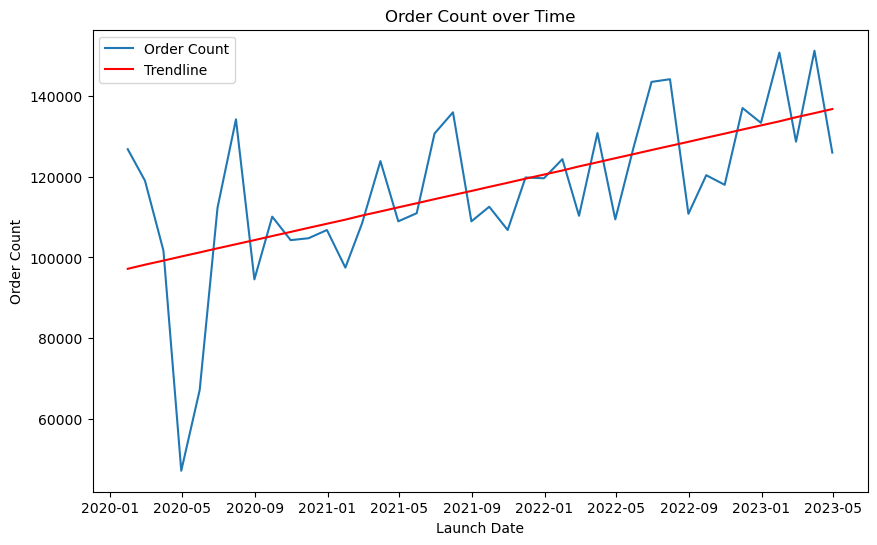

In [10]:
# Convert the index to a datetime index
grouped_df_monthly.index = pd.to_datetime(grouped_df_monthly.index)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped_df_monthly.index, grouped_df_monthly['ORDER_COUNT'], label='Order Count')
plt.xlabel('Launch Date')
plt.ylabel('Order Count')
plt.title('Order Count over Time')

# Fit a polynomial regression line (1st degree)
x = np.arange(len(grouped_df_monthly.index))
y = grouped_df_monthly['ORDER_COUNT']
coefficients = np.polyfit(x, y, deg=1)
trendline = np.polyval(coefficients, x)
plt.plot(grouped_df_monthly.index, trendline, color='red', label='Trendline')

plt.legend()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62949D+01    |proj g|=  2.67664D+01

At iterate    5    f=  7.66961D+00    |proj g|=  8.37986D-01

At iterate   10    f=  7.39254D+00    |proj g|=  4.91256D-01

At iterate   15    f=  7.29755D+00    |proj g|=  2.83903D-01

At iterate   20    f=  7.20852D+00    |proj g|=  9.00832D-01

At iterate   25    f=  7.15010D+00    |proj g|=  3.51009D-01

At iterate   30    f=  7.14071D+00    |proj g|=  6.72479D-02

At iterate   35    f=  7.14018D+00    |proj g|=  5.28945D-02

At iterate   40    f=  7.12834D+00    |proj g|=  2.01746D-01

At iterate   45    f=  7.08256D+00    |proj g|=  4.39192D-01

At iterate   50    f=  7.06699D+00    |proj g|=  1.43977D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

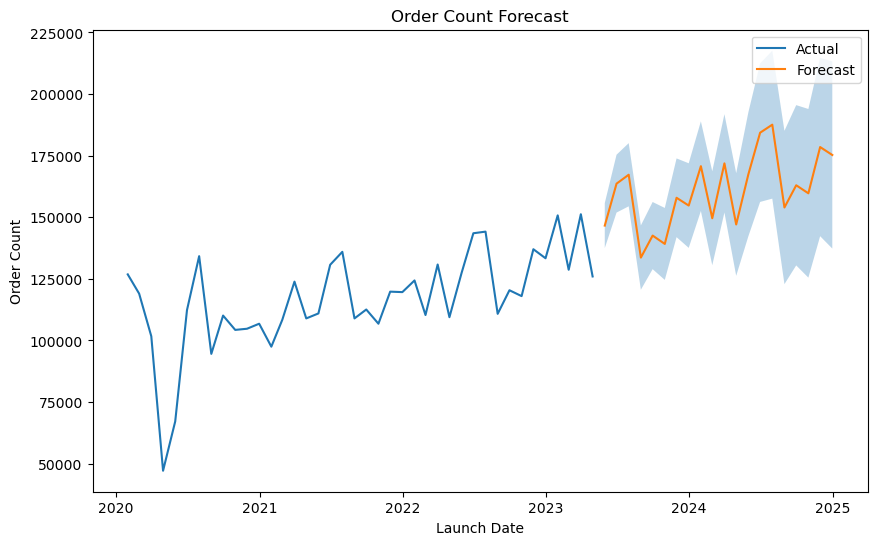

In [11]:
# Specify the SARIMA parameters
order = best_params
seasonal_order = (1, 1, 0, 12)  # (P, D, Q, S)

# Seasonal_order of (1, 1, 0, 12) was applied because it is the typical seasonal order of data that is represented monthly.
# Ideal

# Fit the SARIMA model
model = SARIMAX(grouped_df_monthly['ORDER_COUNT'], order=order, seasonal_order=seasonal_order)
result = model.fit()

# Forecast the ORDER_COUNT values for the future dates
future_dates = pd.date_range(start=grouped_df.index[-2] + pd.DateOffset(months=0), periods=20, freq='M')
forecast = result.get_forecast(steps=len(future_dates), index=future_dates)

# Get the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Slice the actual values to match the length of forecasted values
actual_values = grouped_df_monthly['ORDER_COUNT'][-len(forecast_values):]

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, forecast_values)
mse = mean_squared_error(actual_values, forecast_values)
rmse = mse ** 0.5

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(grouped_df_monthly.index, grouped_df_monthly['ORDER_COUNT'], label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast')
plt.fill_between(forecast_values.index, confidence_intervals['lower ORDER_COUNT'], confidence_intervals['upper ORDER_COUNT'], alpha=0.3)
plt.xlabel('Launch Date')
plt.ylabel('Order Count')
plt.title('Order Count Forecast')
plt.legend()

plt.savefig('forecast.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# We print our predictions for the follwing months

forecast_values = forecast.predicted_mean.loc['2023-09':'2024-08']
forecast_values.index = forecast_values.index.strftime('%Y-%m')

print("\n")
forecast_values

2023-09    142569.297997
2023-10    139183.950356
2023-11    157908.899162
2023-12    154751.918836
2024-01    170734.293712
2024-02    149599.341645
2024-03    171880.373629
2024-04    147074.204099
2024-05    167411.683788
2024-06    184314.017137
2024-07    187572.349778
2024-08    153971.963923
Name: predicted_mean, dtype: float64

In [13]:
# We print our condifence intervals

confidence_intervals.index = confidence_intervals.index.strftime('%Y-%m')

print("\n")
confidence_intervals

,lower ORDER_COUNT,upper ORDER_COUNT
2023-05,137492.332429,155750.550739
2023-06,151901.872330,175378.670268
2023-07,154445.099526,180079.470994
2023-08,120584.367460,146694.803233
2023-09,128939.732208,156198.863787
2023-10,124584.374481,153783.526230
2023-11,141933.827439,173883.970886
2023-12,137588.431920,171915.405751
2024-01,152547.277217,188921.310207
2024-02,130532.627951,168666.055339


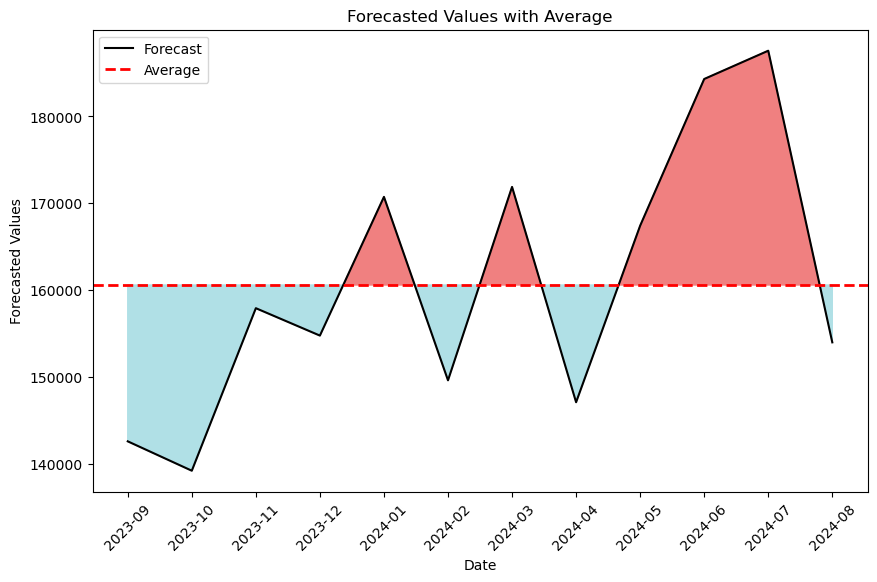

In [14]:
# Calculate the average of the forecasted values
average_forecast = forecast_values.mean()

# Plot the forecasted values
plt.figure(figsize=(10, 6))

# Color light red for values above average
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='black')
plt.fill_between(forecast_values.index, forecast_values, average_forecast, where=forecast_values > average_forecast, interpolate=True, color='lightcoral')

# Color green for values below average
plt.fill_between(forecast_values.index, forecast_values, average_forecast, where=forecast_values < average_forecast, interpolate=True, color='powderblue')

# Plot the average line with thicker line width
plt.axhline(average_forecast, color='r', linestyle='--', label='Average', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.title('Forecasted Values with Average')
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust tick frequency to include all dates
plt.xticks(forecast_values.index)

plt.show()


In [15]:
grouped_df_monthly.index = grouped_df_monthly.index.strftime('%Y-%m')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62949D+01    |proj g|=  2.67664D+01

At iterate    5    f=  7.66961D+00    |proj g|=  8.37986D-01

At iterate   10    f=  7.39254D+00    |proj g|=  4.91256D-01

At iterate   15    f=  7.29755D+00    |proj g|=  2.83903D-01

At iterate   20    f=  7.20852D+00    |proj g|=  9.00832D-01


 This problem is unconstrained.



At iterate   25    f=  7.15010D+00    |proj g|=  3.51009D-01

At iterate   30    f=  7.14071D+00    |proj g|=  6.72479D-02

At iterate   35    f=  7.14018D+00    |proj g|=  5.28945D-02

At iterate   40    f=  7.12834D+00    |proj g|=  2.01746D-01

At iterate   45    f=  7.08256D+00    |proj g|=  4.39192D-01

At iterate   50    f=  7.06699D+00    |proj g|=  1.43977D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   1.440D-01   7.067D+00
  F =   7.0669872454848246     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Mean Absolute Error (MAE): 34467.79356334959
Mean S

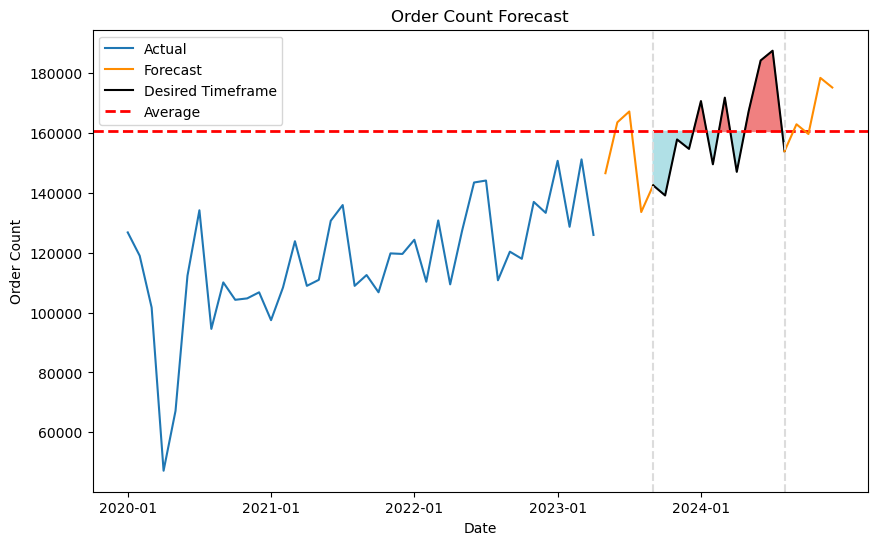

In [16]:
# Specify the SARIMA parameters
order = best_params
seasonal_order = (1, 1, 0, 12)  # (P, D, Q, S)

# Fit the SARIMA model
model = SARIMAX(grouped_df_monthly['ORDER_COUNT'], order=order, seasonal_order=seasonal_order)
result = model.fit()

# Forecast the ORDER_COUNT values for the future dates
future_dates = pd.date_range(start=grouped_df.index[-2] + pd.DateOffset(months=0), periods=20, freq='M')
forecast = result.get_forecast(steps=len(future_dates), index=future_dates)

# Get the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Slice the actual values to match the length of forecasted values
actual_values = grouped_df_monthly['ORDER_COUNT'][-len(forecast_values):]
actual_values.index = forecast_values.index  # Assign the same index as forecast_values

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, forecast_values)
mse = mean_squared_error(actual_values, forecast_values)
rmse = mse ** 0.5

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual data and the forecasted values
plt.figure(figsize=(10, 6))

# Plot the actual data
plt.plot(grouped_df_monthly.index, grouped_df_monthly['ORDER_COUNT'], label='Actual')

# Plot the forecasted values
forecast_values1 = forecast.predicted_mean.loc['2023-05':'2023-09']
forecast_values1.index = forecast_values1.index.strftime('%Y-%m')
forecast_values2 = forecast.predicted_mean.loc['2024-08':'2025-01']
forecast_values2.index = forecast_values2.index.strftime('%Y-%m')

forecast_values = forecast.predicted_mean.loc['2023-09':'2024-08']
forecast_values.index = forecast_values.index.strftime('%Y-%m')

# Calculate the average of the forecasted values
average_forecast = forecast_values.mean()

plt.plot(forecast_values1.index, forecast_values1, label='Forecast', color='darkorange')

plt.plot(forecast_values.index, forecast_values, label='Desired Timeframe', color='black')
plt.fill_between(forecast_values.index, forecast_values, average_forecast, where=forecast_values > average_forecast, interpolate=True, color='lightcoral')
plt.fill_between(forecast_values.index, forecast_values, average_forecast, where=forecast_values < average_forecast, interpolate=True, color='powderblue')
plt.axhline(average_forecast, color='r', linestyle='--', label='Average', linewidth=2)

plt.plot(forecast_values2.index, forecast_values2, color='darkorange')

plt.xlabel('Date')
plt.ylabel('Order Count')
plt.title('Order Count Forecast')
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=0)

# Show only the first index and every other year
x_ticks = plt.gca().get_xticks()
plt.gca().set_xticks(x_ticks[::12])

# Add vertical lines
plt.axvline('2023-09', color='gainsboro', linestyle='--', label='Vertical Line 1')
plt.axvline('2024-08', color='gainsboro', linestyle='--', label='Vertical Line 2')

plt.savefig('order_count_forecast.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
# Finally, we export our results in .csv format

export = pd.DataFrame({'Forecast': forecast_values})
export["Average"] = average_forecast
export["Difference"] = export["Forecast"] - export["Average"]

export

,Forecast,Average,Difference
2023-09,142569.297997,160581.024505,-18011.726508
2023-10,139183.950356,160581.024505,-21397.074150
2023-11,157908.899162,160581.024505,-2672.125343
2023-12,154751.918836,160581.024505,-5829.105670
2024-01,170734.293712,160581.024505,10153.269207
2024-02,149599.341645,160581.024505,-10981.682860
2024-03,171880.373629,160581.024505,11299.349124
2024-04,147074.204099,160581.024505,-13506.820406
2024-05,167411.683788,160581.024505,6830.659283
2024-06,184314.017137,160581.024505,23732.992632


In [18]:
export.to_csv("Amount_To_Be_Produced.csv", index=True)

In [19]:
best_params

(4, 1, 4)